# Part 2: Animal Density Demo

If you haven't looked at Part 1 yet, you may want to - it shows how we get our density data all in one place and formatting the way we want so that it's easier to work with here in Part 2. 

In Part 2, we're going to dive into the worlds of raster and vector data. The purpose of this tutorial/notebook is to walk through the steps of computing the average density value within a given polygon area. The polygon areas we'll be working with are offshore wind lease areas. 

In [1]:
# Imports!
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

## Lease Area Shapefiles

For this part, you will need to grab the BOEM lease area shapefiles from the [BOEM Renewable Energy GIS Data site](https://www.boem.gov/renewable-energy/mapping-and-data/renewable-energy-gis-data). In particular, we'll be working with the "Wind Lease Outlines", which are namded like `Wind_Lease_Outlines_11_16_2023.*`. These will need to be downloaded and then placed into the data/lease_areas folder. Note that one single shapefile actually consists of several files with the same name and different extensions.

    |--data
        |-- lease_areas
            |-- Wind_Lease_Outlines_11_16_2023.prj
            |-- Wind_Lease_Outlines_11_16_2023.shp
            |-- etc...

In [2]:
# Path to the main shapefile (the one with the *.shp extension). Note that this shapefile 
# contains all of the individual lease area polygons.
lease_area_shapefile_path = "../data/lease_areas/Wind_Lease_Outlines_11_16_2023.shp"

# Import the shapefile to a geodataframe. 
gdf_lease_areas_all = gpd.read_file(lease_area_shapefile_path)

# Extract a subset that only includes "Commercial" lease types on the east coast
gdf_lease_areas = gdf_lease_areas_all[(gdf_lease_areas_all['LEASE_TYPE'] == 'Commercial') &
                                      (gdf_lease_areas_all['Shape_Area'] > 0.001) &
                                      (gdf_lease_areas_all['STATE'] != 'CA') &
                                      (gdf_lease_areas_all['STATE'] != 'Louisiana/Texas')]

# Lease area selection, hard-coded for testing.
lease_area_selection = "OCS-A 0486 - Revolution Wind, LLC"



## Set the buffer size

Here's where we're setting the buffer size. This would normally be based on something scientifically/physically meaningful, but here we're just choosing a fairly arbitrary distance as our buffer - 10km. 


In [49]:
# Buffer size in meters
buffer_size = 10000

## Point to the raster data

Now we need to point to the geotiffs that we created back in Part 1. For this example, we're going to just specify one single geotiff that we'll use as an example (Atlantic spotted dolphin, month 1/January).

In [50]:
# Raster file selection, hard-coded for testing
raster_file_path = "../data/density_geotiffs/Fin_whale.month07.tif"


## Zonal Statistics

The density data and the BOEM polygons are not in the same projection. The density file uses an Albers Equal Area projection while the lease area shapefiles are in geographic coordinates (latitude and longitude). In order to do the zonal stats we'll basically be placing a polygon on the raster, like a cookie cutter, and using that footprint to pick out the "pixels" to include in our average. For that to work, the projections need to match. 

It's a little more straightforward to adjust the projection of the polygon than the geotif, so that's what we'll do. 

In [51]:
raster_src = rasterio.open(raster_file_path)
raster_img = raster_src.read(1)

# Get the CRS (Coordinate Reference System) of the raster data file
raster_crs = raster_src.crs


At this stage we've imported the raster file and we've grabbed info about the projection/CRS. it's not a bad idea to just check that the file looks approximately correct. So let's plot the raster we just imported.

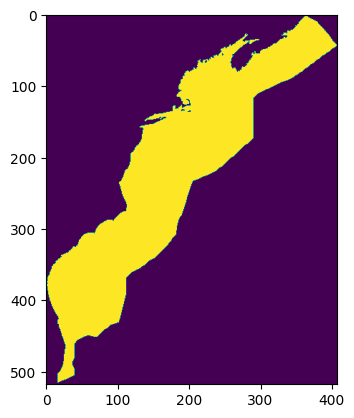

In [52]:
plt.imshow(raster_img)

We know that this data is from the east coast of the US, and we can see that this map at least shows the outline of the coast. But the colors are wrong. The area that's yellow should be showing some color gradients. 

The reason it looks weird here is because the plotting tool thinks that the areas outside the data areas are numbers, when in fact they are just placeholders, also called "nodata". So let's maske out the nodata values and try again. 

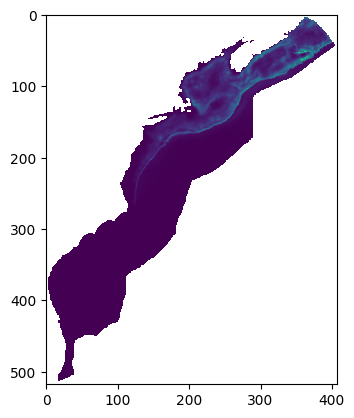

<Axes: >

In [53]:
raster_img_masked = raster_src.read(1, masked=True)
cmap = plt.cm.viridis  # Or any other colormap
cmap.set_bad('white', 1.) 
show(raster_img_masked, cmap=cmap, adjust='linear')

Now that we've successfully plotted the raster image, we can move on to reprojecting the lease area to match. In the image below, the raster and the polygon are plotted together. That tiny little red blob is our polygon!

<Axes: >

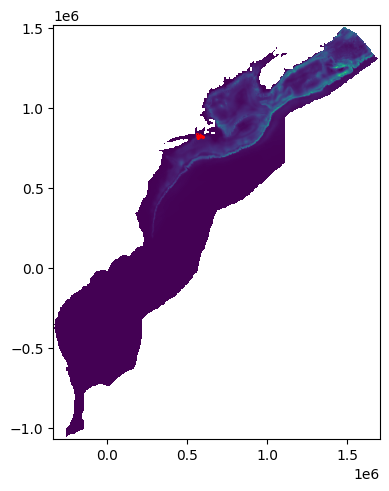

In [54]:
# Now reproject the lease area to match the raster data
gdf_lease_area_reprojected = gdf_lease_areas.to_crs(raster_crs)

# Select only the polygon corresponding to the current selection
gdf_selected = gdf_lease_area_reprojected[gdf_lease_area_reprojected['LEASE_NU_1'] == lease_area_selection]

# Plot the raster with the polygon
fig, ax = plt.subplots(constrained_layout=True)
show(raster_img_masked, ax=ax, transform=raster_src.transform, cmap=cmap, adjust='linear')
gdf_selected.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2, linestyle='--')


## Load coastlines

In [55]:
coastline_file = "../data/shapefiles/eastcoast.shp"
gdf_coast = gpd.read_file(coastline_file)
# Reproject the coastline to match the raster
gdf_coast_projected = gdf_coast.to_crs(raster_crs)


## Computing the zonal statistics

Now we have the cookie-cutter all set up! We can actually do our zonal statistics now. The way we're approaching this is to use the polygon to make a mask that will select any of the raster pixels that are either partially or fully overlapping with the polygon. 

In [56]:
# Create a buffered polygon
buffered_lease_area = gdf_selected.geometry.buffer(buffer_size)

# mask the raster using the selected lease area polygon
out_image, _ = mask(raster_src, buffered_lease_area, crop=True)
overlap_area = out_image[0]

# Add a buffer around the buffer area - for plotting purposes
plot_buffer_size = 300000
buffered_plot_area = buffered_lease_area.buffer(plot_buffer_size)
out_image_for_plotting, _ = mask(raster_src, buffered_plot_area, crop=True)
raster_plot_area = out_image_for_plotting[0]

Here's the part where we are actually taking the mean of the overlapping cells. We're also grabbing the min and max values of the larger buffer area to help us scale the colors on our final plot.

In [57]:
# Compute the mean, excluding no data values (assuming they are np.nan or a defined no data value for your raster)
no_data_value = raster_src.nodata  # Get no data value from raster metadata if available
if no_data_value is not None:
    # Mean value within the buffer area
    mean_value = np.mean(overlap_area[overlap_area != no_data_value])
    # For plot color extents
    min_value = np.min(raster_plot_area[raster_plot_area != no_data_value])
    max_value = np.max(raster_plot_area[raster_plot_area != no_data_value])
else:
    # Mean value within the buffer area
    mean_value = np.mean(overlap_area[np.isfinite(overlap_area)])
    # For plot color extents
    min_value = np.min(raster_plot_area[np.isfinite(raster_plot_area)])
    max_value = np.max(raster_plot_area[np.isfinite(raster_plot_area)])



Let's print that result:

In [58]:
formatted_string = (f"The mean animal density in the polygon area is {mean_value:.1e}" 
                    f" animals per 100 square kilometers.")
print(formatted_string)

The mean animal density in the polygon area is 2.7e-01 animals per 100 square kilometers.


We now have the full process for computing average density in the polygon area. As a last step, we're going to plot it.

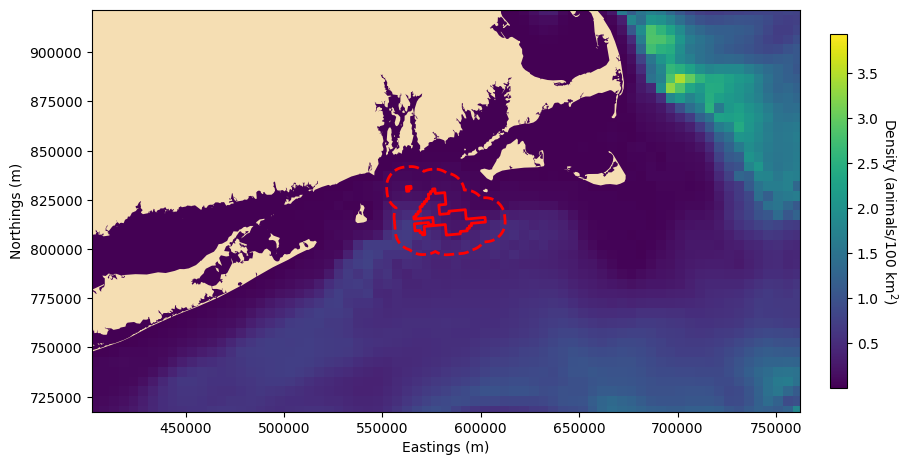

In [59]:
fig, ax = plt.subplots(figsize=(9, 9), constrained_layout=True)

# Get the bounds of the buffered polygon for zooming in the plot
minx, miny, maxx, maxy = buffered_plot_area.iloc[0].bounds

im = ax.imshow(raster_plot_area, cmap='viridis', vmin=min_value, vmax=max_value,
               extent=[minx, maxx, miny, maxy], origin='upper')

# show(raster_src, ax=ax)

ax.set_aspect('equal')
ax.set_xlabel('Eastings (m)')
ax.set_ylabel('Northings (m)')
# ax.set_title(lease_area_selection + " - " +
#              f"{buffer_size/1000:.0f}-km buffer\n"
#              f"Mean density inside buffer: " + f"{mean_value:.0e} "
#              f"animals per 100 km$^2$")

# Overlay the coastline
gdf_coast_projected.boundary.plot(ax=ax, facecolor='wheat', linewidth=0)

# Overlay the polygon(s) from the GeoDataFrame
gdf_selected.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)

# Overlay the buffered polygon
buffered_lease_area.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2, linestyle='--')

ax.set_ylim([miny+220000, maxy-220000])
ax.set_xlim([minx+150000, maxx-150000])

# Add colorbar
cbar = fig.colorbar(im, ax=ax, fraction=0.025, pad=0.04)

# Label the colorbar
cbar.set_label('Density (animals/100 km$^2$)', rotation=270, labelpad=15)

plt.savefig("../images/density_buffer_plots/example_buffer_plot_zoom_out.png", bbox_inches='tight')